In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from google.colab import drive
from array import array
import pandas as pd
import os
import seaborn as sns
drive.mount('/content/gdrive') # 此處需要登入google帳號
data = pd.read_csv("/content/gdrive/My Drive/thesis/thesisdataset/millan_average7_396.csv")
data.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(1679994, 3)

In [ ]:
data2 = pd.read_csv("/content/gdrive/My Drive/thesis/thesisdataset/germany_average3_41.csv")
data2.shape

(1296000, 7)

In [ ]:
data3 = pd.read_csv("/content/gdrive/My Drive/thesis/thesisdataset/uk_data_average5_69_v1.csv")
data3.shape

(19888, 2)

In [ ]:
!nvidia-smi

Mon May 23 03:30:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
df = pd.DataFrame(data)
dataset = df.internet.values.astype(float)

In [ ]:
df2 = pd.DataFrame(data2)
dataset2 = df2.load.values.astype(float)

In [ ]:
df3 = pd.DataFrame(data3)
dataset3 = df3.internet.values.astype(float)

In [ ]:
dataset1000=np.append(dataset2, dataset3)
dataset1000=np.append(dataset1000, dataset)

In [ ]:
dataset1000.shape

(2995882,)

In [ ]:
dataset1000

array([[0.0014237 ],
       [0.00455975],
       [0.01509594],
       ...,
       [0.00519959],
       [0.00440306],
       [0.00418464]])

In [ ]:
dataset1000.shape

(2995882, 1)

In [ ]:
dataset1000=dataset1000.reshape(-1,1)

In [ ]:
dataset1000.shape

(2995882, 1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
dataset1000 = sc.fit_transform(dataset1000)

seq_length = 1
x, y = sliding_windows(dataset1000, seq_length)
train_size = 2097000
# test_size = 898761
#train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
print(trainX.shape)

torch.Size([2097000, 1, 1])


In [ ]:
print(trainY.shape)

torch.Size([2097000, 1])


In [ ]:
print(testX.shape)

torch.Size([898881, 1, 1])


In [ ]:
print(testY.shape)

torch.Size([898881, 1])


In [ ]:
print(testX.shape)
print(testY.shape)

torch.Size([898881, 1, 1])
torch.Size([898881, 1])


In [ ]:
testX=testX.reshape(898881,1,1)
testY=testY.reshape(898881,1)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)L
# Train the model
Loss=[]
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    running_loss = loss.item()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      Loss.append(running_loss)
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
Loss0 = np.array(Loss)

Epoch: 0, loss: 0.12591
Epoch: 100, loss: 0.00012
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00010
Epoch: 400, loss: 0.00010
Epoch: 500, loss: 0.00009
Epoch: 600, loss: 0.00009
Epoch: 700, loss: 0.00008
Epoch: 800, loss: 0.00008
Epoch: 900, loss: 0.00008
Epoch: 1000, loss: 0.00008
Epoch: 1100, loss: 0.00008
Epoch: 1200, loss: 0.00007
Epoch: 1300, loss: 0.00007
Epoch: 1400, loss: 0.00007
Epoch: 1500, loss: 0.00007
Epoch: 1600, loss: 0.00007
Epoch: 1700, loss: 0.00007
Epoch: 1800, loss: 0.00007
Epoch: 1900, loss: 0.00007


In [ ]:
joblib.dump(lstm,"/content/gdrive/My Drive/thesis/lstm0402.pkl")

['/content/gdrive/My Drive/thesis/lstm0402.pkl']

In [ ]:
from math import sqrt

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


print("mean_absolute_error:",mean_absolute_error(dataY_plot, data_predict))

print("mean_squared_error:",mean_squared_error(dataY_plot, data_predict))

print("rmse:",sqrt(mean_squared_error(dataY_plot, data_predict)))

print("r2 score:",r2_score(dataY_plot, data_predict))
print("mape_sk", mean_absolute_percentage_error(dataY_plot, data_predict))

mean_absolute_error: 3.235951
mean_squared_error: 35.566257
rmse: 5.9637452558611725
r2 score: 0.7047958506159802
mape_sk 141221450000.0


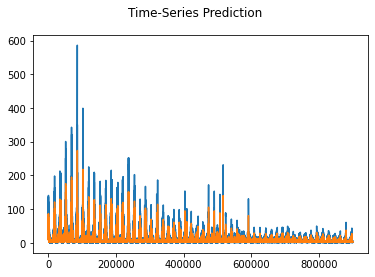

In [ ]:
#V seq=1 168000
lstm.eval()
test_predict = lstm(testX)

test_predict = test_predict.data.numpy()
testY_plot = testY.data.numpy()

test_predict = sc.inverse_transform(test_predict)
testY_plot = sc.inverse_transform(testY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(testY_plot)
plt.plot(test_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
from math import sqrt

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


print("mean_absolute_error:",mean_absolute_error(testY_plot, test_predict))

print("mean_squared_error:",mean_squared_error(testY_plot, test_predict))

print("rmse:",sqrt(mean_squared_error(testY_plot, test_predict)))

print("r2 score:",r2_score(testY_plot, test_predict))
print("mape_sk", mean_absolute_percentage_error(testY_plot, test_predict))

mean_absolute_error: 3.8686788
mean_squared_error: 85.017525
rmse: 9.220494819652483
r2 score: 0.7015686309063682
mape_sk 542698200000.0


In [ ]:
testY_plot_df.to_csv('/content/gdrive/My Drive/thesis/testY_plot_df_64.csv',index=False)

In [ ]:
test_predict_lstm=test_predict.astype(np.float64)
test_predict_lstm_df=pd.DataFrame(test_predict_lstm)
test_predict_lstm_df.to_csv('/content/gdrive/My Drive/thesis/test_predict_lstm_df_64.csv',index=False)

In [ ]:
dfprediction = pd.read_csv('/content/gdrive/My Drive/thesis/dfprediction0402_2.csv')
dfprediction.shape

(898760, 1)